# regression and model assessment

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax
# import dmol

In [17]:
soldata = pd.read_csv("data/curated-solubility-dataset.csv")

features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

## 3.2 overfitting

In [18]:
# Get 50 points and split into train/test
sample = soldata.sample(50, replace=False)
train = sample[:25]
test = sample[25:]

# standardize the features using only train
test[feature_names] -= train[feature_names].mean()
test[feature_names] /= train[feature_names].std()
train[feature_names] -= train[feature_names].mean()
train[feature_names] /= train[feature_names].std()

# convert from pandas dataframe to numpy arrays
x = train[feature_names].values
y = train["Solubility"].values
test_x = test[feature_names].values
test_y = test["Solubility"].values

/tmp/ipykernel_64053/3815087055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[feature_names] -= train[feature_names].mean()
/tmp/ipykernel_64053/3815087055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[feature_names] /= train[feature_names].std()
/tmp/ipykernel_64053/3815087055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [19]:
# define our loss function
@jax.jit
def loss(w, b, x, y):
    return jnp.mean((y - jnp.dot(x, w) - b) ** 2)


loss_grad = jax.grad(loss, (0, 1))
w = np.random.normal(size=x.shape[1])
b = 0.0
loss_grad(w, b, x, y)

(Array([ 1.0654202 ,  6.839894  ,  2.049898  ,  0.6326658 , -3.1080203 ,
        -3.6846342 , -2.816171  , -3.9710429 ,  0.61440116,  0.94064313,
         2.3410985 ,  2.1644928 ,  2.6752493 , -4.0455976 ,  0.83169645,
         0.6160082 ,  0.44235563], dtype=float32),
 Array(6.295369, dtype=float32, weak_type=True))

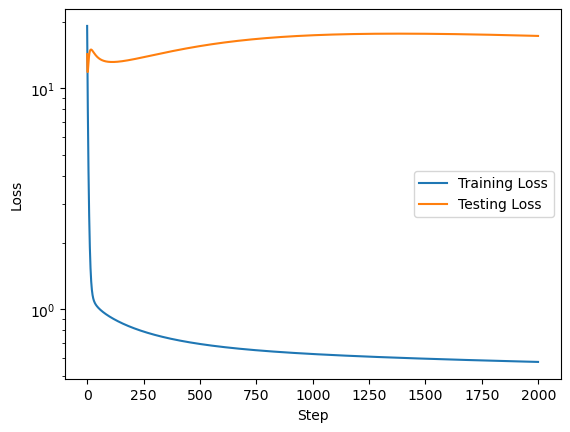

In [20]:
loss_progress = []
test_loss_progress = []
eta = 0.05
for i in range(2000):
    grad = loss_grad(w, b, x, y)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss(w, b, x, y))
    test_loss_progress.append(loss(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

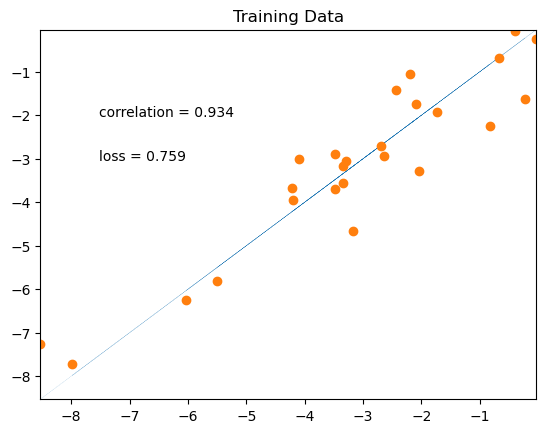

In [21]:
yhat = x @ w + b
plt.plot(y, y, ":", linewidth=0.2)
plt.plot(y, x @ w + b, "o")
plt.xlim(min(y), max(y))
plt.ylim(min(y), max(y))
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((y - yhat)**2)):.3f}")
plt.title("Training Data")
plt.show()

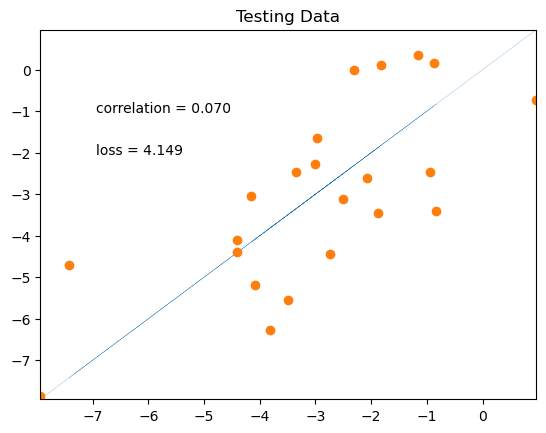

In [22]:
yhat = test_x @ w + b
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

### overfitting with synthetic data

In [23]:
# generate data from polynomial
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_features = np.vstack([syn_x**3, syn_x**2, syn_x, np.ones_like(syn_x)]).T
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1

/tmp/ipykernel_64053/4247135150.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


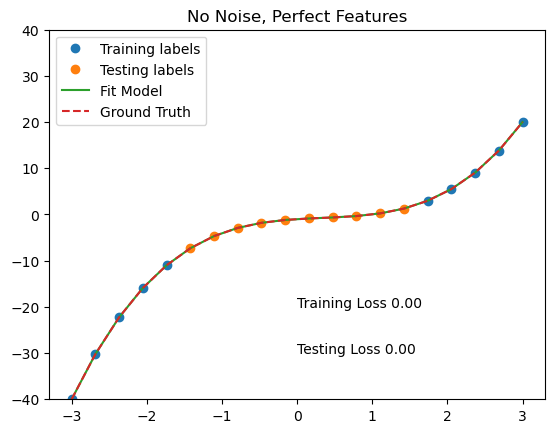

In [24]:
# split data into train/test
indices = list(range(0, N // 4)) + list(range(3 * N // 4, N))
test_indices = list(range(N // 4, 3 * N // 4))
train_x = syn_features[indices]
train_y = syn_labels[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

# fit using numpy least squares method.
w, *_ = np.linalg.lstsq(train_x, train_y)

# plotting code
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("No Noise, Perfect Features")
plt.show()

In [25]:
train_y = train_y + np.random.normal(scale=5, size=train_y.shape)

/tmp/ipykernel_64053/2494035002.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


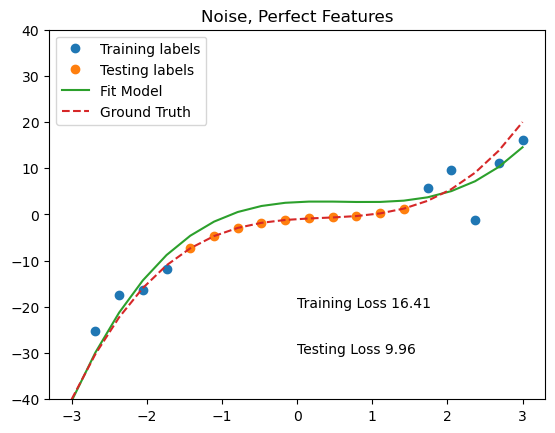

In [26]:
w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("Noise, Perfect Features")
plt.show()

In [27]:
syn_features = np.vstack([syn_x**i for i in range(7)]).T

/tmp/ipykernel_64053/3756951946.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


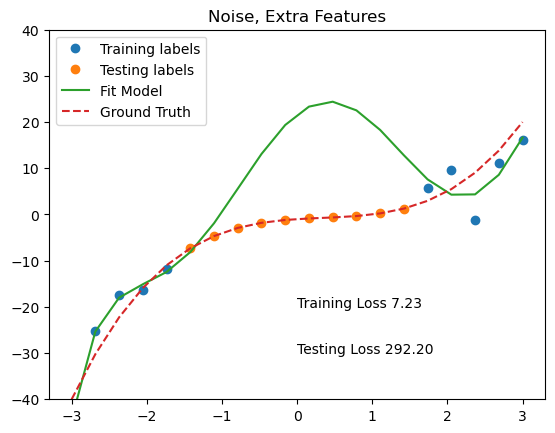

In [28]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend(loc="upper left")
plt.title("Noise, Extra Features")
plt.show()

In [29]:
syn_features = np.vstack(
    [syn_x**2, syn_x, np.exp(-(syn_x**2)), np.cos(syn_x), np.ones_like(syn_x)]
).T

/tmp/ipykernel_64053/3614490283.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


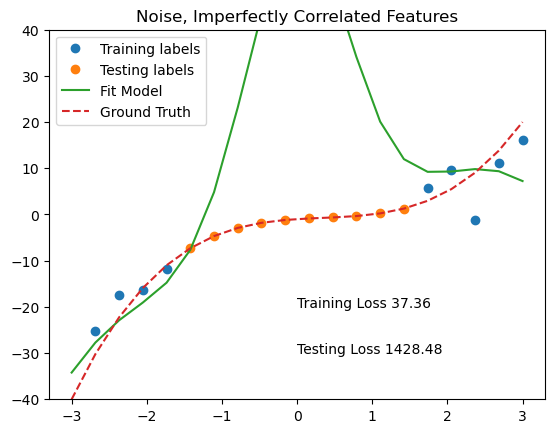

In [30]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend(loc="upper left")
plt.title("Noise, Imperfectly Correlated Features")
plt.show()

## 3.3 exploring effect of feature number

## 3.4 Bias variance decomposition

## 3.5 Regularization

## 3.6 Strategies to Assess Models

## 3.7 Computing other measures

## 3.8 Training Data Distribution

# Exercises

3.10.1.1 What happens if we have redundant features but no noise? Is it possible to overfit?

3.10.1.2
We said that increasing dataset size reduces model variance. Show this by using k-fold cross-validation on a few different dataset sizes.

3.10.2.1 Implement L1 regularization on the solubility data with data points. Increase the strength until some feature coefficients ($w_i$) go to zero. Which ones are they? Why do you think they go to zero first?

3.10.2.2 Repeat 3.10.2.1 with a few different sets of training data. Are your results consistent on which features disappear? Based on your results, do you think there is meaning to the features which go to zero?

3.10.2.3 Implement the L-infinity (supremum norm) regularization, which returns the maxmium of the absolute values of the elements.

3.10.3.1 Develop the best linear model for the complete solubility dataset and assess using your best judgment. Justify your choice of model and assessment.